In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as sps
import scipy.optimize as spo
import scipy.signal as spg

from collections import namedtuple
import pandas as pd
import os
from scipy.stats import t

import sys
import scipy.io as io
from scipy.optimize import curve_fit

In [2]:
def expfunc(x, a, b, c):
    return a * np.exp(-b * x) + c

def getz(alpha):
    z = sps.norm.ppf(1 - alpha/2)
    return z

def gett(alpha, n):
    tinv = lambda p, df: abs(t.ppf(p/2, df))
    ts = tinv(alpha, n-2)
    return ts

def corrCI(x, y, alpha): #from Zou 2007, comparing r values
    r, p = sps.pearsonr(x,y)
    z = getz(alpha)
    r_z = np.arctanh(r)
    se= 1/np.sqrt(x.size-3)
    z = sps.norm.ppf(1 - alpha/2)
    
    lo_z, up_z = r_z - z*se, r_z + z*se
    lo, up = np.tanh((lo_z, up_z))
    return [r, p, lo, up]

def corrCIdiff(r1, l1, u1, r2, l2, u2): #from Zou 2007
    
    ldiff = r1 - r2 - np.sqrt( (r1 - l1)**2 + (u2 - r2)**2  )
    udiff = r1 - r2 + np.sqrt( (u1 - r1)**2 + (r2 - l2)**2  )
    rdiff = r1 - r2
    return [rdiff, ldiff, udiff]

def regresiduals(x, y):
    xsum = sum((x - np.mean(x))**2)
    ysum = sum((y - np.mean(y))**2)
    xysum = sum((x - np.mean(x))* (y-np.mean(y)))
    return [xsum, xysum, ysum]

def regCI(x,y,n, alpha):
    linreg0 = sps.stats.linregress(np.abs(x), y)
    res0 = regresiduals(x,y)
    ts = gett(alpha, n)
    xi = np.linspace(0, max(x))
    syi = np.empty(len(xi))
    for xp, c in enumerate(xi):
        syi[xp] = np.sqrt(linreg0.stderr**2 * res0[0]  * (1/n + (c - np.mean(x))**2 /  res0[0]))
    yi = linreg0.intercept + linreg0.slope*xi
    y1 = linreg0.intercept + linreg0.slope*xi + ts*syi
    y2 = linreg0.intercept + linreg0.slope*xi - ts*syi
    return [xi, yi, y1, y2]

def slopediff(x1, y1, x2, y2, n1, n2):
    #Zar pg 363
    linreg1 = sps.stats.linregress(np.abs(x1), np.abs(y1))
    linreg2 = sps.stats.linregress(np.abs(x2), np.abs(y2))
    res1 = regresiduals(np.abs(x1), np.abs(y1))
    resSS1 = res1[2] - (res1[1]**2/res1[0] )
    res2 = regresiduals(np.abs(x2), np.abs(y2))
    resSS2 = res2[2] - (res2[1]**2/res2[0] )
    
    #calculate S_squared and Sb1 - Sb2 
    ssq = (resSS1 + resSS2)/ (n1 + n2)
    sbminusb = np.sqrt((ssq/res1[0]) + (ssq/res2[0]) )
    
    #calculate difference between slopes, the p value, and confidence intervals, t test
    slpt = (linreg1.slope - linreg2.slope )/ sbminusb 
    slpp = sps.norm.sf(abs(slpt))*2 #formula to get a p value from a t test
    return [slpt, slpp]

def elediff(x1, y1, x2, y2, n1, n2):
    #Zar pg 367
    linreg1 = sps.stats.linregress(np.abs(x1), np.abs(y1))
    linreg2 = sps.stats.linregress(np.abs(x2), np.abs(y2))
    res1 = regresiduals(np.abs(x1), np.abs(y1))
    resSS1 = res1[2] - (res1[1]**2/res1[0] )
    res2 = regresiduals(np.abs(x2), np.abs(y2))
    resSS2 = res2[2] - (res2[1]**2/res2[0] )
    
    #calculate S_squared and Sb1 - Sb2 
    ssq = (resSS1 + resSS2)/ (n1 + n2)
    sbminusb = np.sqrt((ssq/res1[0]) + (ssq/res2[0]) )
    
    s2yxc = ((res1[2] + res2[2]) - ( (res1[1] + res2[1])**2 / (res1[0] + res2[0]) ))/ \
           (n1 + n2 - 3)
    bc = (res1[1]+ res2[1]) / (res1[0] + res2[0])
    elvt = ( (np.abs(y1).mean() - np.abs(y2).mean()) - \
        (  (res1[1] + res2[1]) /(res1[0] + res2[0])*(np.abs(x1).mean() - np.abs(x2).mean())  ))\
        / np.sqrt(  s2yxc *(n1**-1 + n2**-1 + \
        ( (np.abs(x1).mean() - np.abs(x2).mean())**2/(res1[0] + res2[0]) ) ) )
    return [elvt, sps.norm.sf(abs(elvt))*2]  

def yintdiff(x1, y1, x2, y2, n1, n2):
    #Zar pg 371
    linreg1 = sps.stats.linregress(np.abs(x1), np.abs(y1))
    linreg2 = sps.stats.linregress(np.abs(x2), np.abs(y2))
    res1 = regresiduals(np.abs(x1), np.abs(y1))
    resSS1 = res1[2] - (res1[1]**2/res1[0] )
    res2 = regresiduals(np.abs(x2), np.abs(y2))
    resSS2 = res2[2] - (res2[1]**2/res2[0] )
    
    #calculate S_squared and Sb1 - Sb2 
    ssq = (resSS1 + resSS2)/ (n1 + n2)
    sbminusb = np.sqrt((ssq/res1[0]) + (ssq/res2[0]) )
    
    bdt = res1[1]/res1[0]
    adt = np.abs(y1).mean() - bdt* np.abs(x1).mean()
    bcz = res2[1]/res2[0]
    acz = np.abs(y2).mean() - bcz* np.abs(x2).mean()
    s2yxp = (resSS1 + resSS2)/ ((n1 - 2 + n2 - 2))
    
    yintt = (adt - acz) / np.sqrt(  s2yxp* (n1**-1 + n2**-1 + \
            (np.abs(x1).mean()**2/ res1[0]) + \
            (np.abs(x2).mean()**2/ res2[0]) )   )
    yintp = sps.norm.sf(abs(yintt))*2
    return [yintt, yintp]

def MWUefsize(a, b):
    #effect size for Mann-Whitney U test
    [u, p] = sps.mannwhitneyu(a,b)
    n1 = a.size
    n2 = b.size
    comm = u/(n1*n2) #common language, just percentage
    rkbiscorr = np.abs(2*u/(n1*n2) - 1) #rank biserial correlation, effect increases as r -> 1
    return [u,p,comm, rkbiscorr]

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return [idx]

def Gaussian(t, ga, gb, gc, gd):
    return ga + np.abs(gb) * np.exp( - ( (t-gc)**2 / gd**2) )

def Sigmoidal(t, sa, sb, sc, sd, se):
    return sa / (1 + np.exp(-sb*(t - sc)/sd)) + se

def within(tval, tmin, tmax):
    return np.sum((tval > tmin) & (tval < tmax))

def between(val, array):
    return array[0] <= val <= array[1]

In [3]:
# matplotlib settings
mpl.rcParams['mathtext.default'] = 'regular'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Arial'


# Reproducible SVG files (including xml ids):
mpl.rcParams['svg.hashsalt'] = '123'
mpl.rcParams['savefig.dpi'] = '300'

# Font sizes:
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] =  12 # default: 'medium' == 10
mpl.rcParams['xtick.labelsize'] = 10 # default: 'medium' == 10
mpl.rcParams['ytick.labelsize'] = 10 # default: 'medium' == 10
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['xtick.major.size'] = 2
mpl.rcParams['ytick.major.size'] = 2


# Other texts:
in_panel_fontsize = 12
bc_indicator_size = in_panel_fontsize

fildir = 'F:\\Various Files\\My Papers\\Shadron and Pena 2022\\eLife Figures\\'
#fildir = 'F:\\Various Files\\SAC Meetings\\2022\\'

In [10]:
#read excel file
dt = pd.read_excel('F:/Shadron_Pena_2022/Shadron_Pena_2022_ruff_removed.xlsx', header = 0, comment = "#")
jv = pd.read_excel('F:/Shadron_Pena_2022/Shadron_Pena_2022_juvenile.xlsx', header = 0, comment = "#")
cz = pd.read_excel('F:/Shadron_Pena_2022/Cazettes_2014_normal.xlsx', header = 0, comment = "#")

In [11]:
#only use units that are good, and are tuned to ITD
dt = dt[dt['Use?'] == 'yes']
allunits = dt.index[~dt['Best ITD'].isnull()].tolist()
#use only the for sure ICx units
icxlist = dt[dt['Nucleus'] == 'ICx']
icx = icxlist.index[~icxlist['Best ITD'].isnull()].tolist()
#set use to be allunits or icx
use = icx

jv = jv[jv['Nucleus'] == 'ICx']

czneurons = np.arange(0, cz.shape[0])
jvneurons = np.arange(0, jv.shape[0])

jvn = jv['Best ITD'].size
czn = cz['Best ITD'].size
dtn = dt['Best ITD'][use].size

In [8]:
linreg = sps.stats.linregress(np.abs(dt['Best ITD'][use]), np.abs(dt['Best Freq'][use]))
czlinreg = sps.stats.linregress(np.abs(cz['Best ITD']), np.abs(cz['Best Freq']))
jvlinreg = sps.stats.linregress(np.abs(jv['Best ITD']), np.abs(jv['Best Freq']))


randnu = np.empty_like(dt['Best ITD'][use])
for n in range(randnu.size):
    randnu[n] = np.random.randint(-8,8,1)

jvrand = np.empty_like(jv['Best ITD'])
for n in range(jvrand.size):
    jvrand[n] = np.random.randint(-8,8,1)

In [9]:
czxi, czyi, czy1, czy2 = regCI(cz['Best ITD'], cz['Best Freq'], czn, 0.05)
dtxi, dtyi, dty1, dty2 = regCI(dt['Best ITD'][use], dt['Best Freq'][use], dtn, 0.05)
jvxi, jvyi, jvy1, jvy2 = regCI(jv['Best ITD'], jv['Best Freq'], jvn, 0.05)


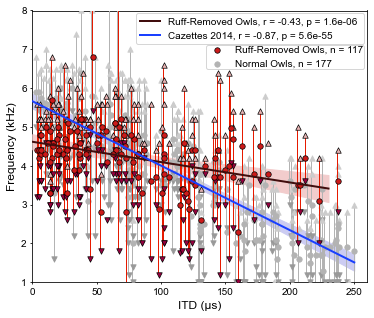

In [18]:
fig, ax = plt.subplots(figsize = [5*1.2,5], facecolor = 'white')

ax.scatter(cz['Best ITD'], cz['Low Freq'], marker = 'v', color = [0.6, 0.6, 0.6],         s=30, linewidths=.7,zorder=5)
ax.scatter(cz['Best ITD'], cz['High Freq'], marker = '^', color = [0.8, 0.8, 0.8],        s=30, linewidths=.7,zorder=5)
czsc = ax.scatter(cz['Best ITD'], cz['Best Freq'], marker = 'o', color = [0.7, 0.7, 0.7], s=30, linewidths=.7,zorder=5, \
       label = f'Normal Owls, n = {czn}')
for ITD in czneurons:
    ax.bar(cz['Best ITD'][ITD], cz['High Freq'][ITD] - cz['Low Freq'][ITD], .7, cz['Low Freq'][ITD], \
           color = [0.7, 0.7, 0.7 ], zorder= 4)

    
ax.scatter(np.abs(dt['Best ITD'][use] + randnu), dt['Low Freq'][use], marker = 'v', color = [0.6, 0, 0.25], \
           linewidths = .7, edgecolor = 'black', s=30, zorder=7)
ax.scatter(np.abs(dt['Best ITD'][use] + randnu), dt['High Freq'][use], marker = '^', color = [0.9, 0.7, 0.7], \
           linewidths = .7, edgecolor = 'black', s=30, zorder=7)
dtsc = ax.scatter(np.abs(dt['Best ITD'][use] + randnu), dt['Best Freq'][use], marker = 'o', color = [0.8, 0.1, 0.1], \
           linewidths = .7, edgecolor = 'black', s=30, zorder=7, label = f'Ruff-Removed Owls, n = {dtn}')
for nurep, ITD  in enumerate(use):
    ax.bar(np.abs(dt['Best ITD'][ITD] + randnu[nurep]), dt['High Freq'][ITD] - dt['Low Freq'][ITD], .7, \
    dt['Low Freq'][ITD], color = [0.9, .1, 0 ], zorder = 6) 
    

czline, = ax.plot(czxi, czyi, color = [0.1, 0.25, 1],  linewidth = 2, \
       label = f'Cazettes 2014, r = {czlinreg.rvalue:.2g}, p = {czlinreg.pvalue:.1e}', zorder = 9)
ax.fill_between(czxi, czy1, czy2, color = [0.8, 0.8, .95], zorder = 1)

dtline, = ax.plot(dtxi, dtyi, color = [0.25, 0.05, 0.05],  linewidth = 2, \
       label = f'Ruff-Removed Owls, r = {linreg.rvalue:.2g}, p = {linreg.pvalue:.1e} ', zorder = 8)
ax.fill_between(dtxi, dty1, dty2, color = [0.95, 0.8, 0.8], zorder = 3)

ax.set_ylim([1000, 8000])
ax.set_xlim([0, cz['Best ITD'].max() + 10])
ax.set_yticks(np.linspace(1000,8000,8))
ax.set_yticklabels([1,2,3,4,5,6,7,8])


plt.ylabel('Frequency (kHz)')
plt.xlabel('ITD (μs)')
legend1 = plt.gca().legend(handles = [dtline, czline], loc= [.31, .875])
ax.add_artist(legend1)
legend2 = plt.gca().legend(handles = [dtsc, czsc], loc = [0.52, 0.785], borderpad = .05)
plt.show()
file_name = 'Haircut_Freq_w_Cazettes_overlay.png'
filname = os.path.join(fildir, file_name)
fig.savefig(filname, bbox_inches='tight')

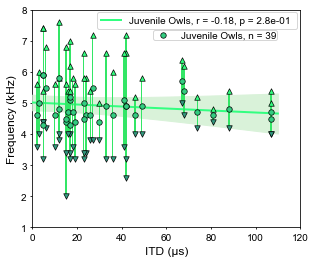

In [17]:
fig, ax = plt.subplots(figsize = [4*1.2,4], facecolor='white')

jvx = np.linspace(0,np.max(jv['Best ITD']),40)

ax.scatter(np.abs(jv['Best ITD']) + jvrand, jv['Low Freq'],  marker = 'v', color = [0.2, 0.6, 0.5], s=30, \
           edgecolor = 'black', linewidths = 0.7, zorder=7)
ax.scatter(np.abs(jv['Best ITD']) + jvrand, jv['High Freq'], marker = '^', color = [0.2, 1.0, 0.5], s=30, \
           edgecolor = 'black', linewidths = 0.7, zorder=7)
jvsc = ax.scatter(np.abs(jv['Best ITD']) + jvrand, jv['Best Freq'], marker = 'o', color = [0.2, 0.8, 0.5], s =30, \
           edgecolor = 'black', linewidths = 0.7, zorder=7, label = f'Juvenile Owls, n = {jvn}')
for ITD in jvneurons:
    ax.bar(np.abs(jv['Best ITD'][ITD+1]) + jvrand[ITD], jv['High Freq'][ITD+1] - jv['Low Freq'][ITD+1], .7, jv['Low Freq'][ITD+1], \
           color = [0.2, 0.9, 0.4 ], zorder= 6)
    
jvline, = ax.plot(jvxi, jvyi, color = [0.2, 1, 0.5],  linewidth = 2, \
       label = f'Juvenile Owls, r = {jvlinreg.rvalue:.2g}, p = {jvlinreg.pvalue:.1e} ', zorder = 5)
ax.fill_between(jvxi, jvy1, jvy2, color = [0.85, 0.95, 0.85], zorder = 4)

ax.set_ylim([1000, 8000])
ax.set_xlim([0, jv['Best ITD'].max() + 10])
ax.set_yticks(np.linspace(1000,8000,8))
ax.set_yticklabels([1,2,3,4,5,6,7,8])
ax.set_facecolor("white")
plt.ylabel('Frequency (kHz)')
plt.xlabel('ITD (μs)')
legend1 = plt.gca().legend(handles = [jvline], loc= [.24, .91])
ax.add_artist(legend1)
legend2 = plt.gca().legend(handles = [jvsc], loc = [0.45, 0.86], borderpad = .05)
plt.show()
file_name = 'Juvenile_only.png'
filname = os.path.join(fildir, file_name)
fig.savefig(filname, bbox_inches='tight')

In [11]:
#MWU Comparisons

In [12]:
ww = np.abs(dt['Best ITD'][use]) <=30
dtbest =                      dt['Best Freq'][use][ww]
czbest = cz[cz['Best ITD']<= 30]['Best Freq']
jvbest = jv[jv['Best ITD']<= 30]['Best Freq']


dthi =                      dt['High Freq'][use][ww]
czhi = cz[cz['Best ITD']<= 30]['High Freq']
jvhi = jv[jv['Best ITD']<= 30]['High Freq']

dtlo =                      dt['Low Freq'][use][ww]
czlo = cz[cz['Best ITD']<= 30]['Low Freq']
jvlo = jv[jv['Best ITD']<= 30]['Low Freq']

In [13]:
cjbest = MWUefsize(czbest, jvbest)
djbest = MWUefsize(dtbest, jvbest)
cdbest = MWUefsize(czbest, dtbest)

In [14]:
#All one Graph

In [15]:
cjhi = MWUefsize(czhi, jvhi)
djhi = MWUefsize(dthi, jvhi)
cdhi = MWUefsize(czhi, dthi)
cjlo = MWUefsize(czlo, jvlo)
djlo = MWUefsize(dtlo, jvlo)
cdlo = MWUefsize(czlo, dtlo)

In [17]:
##Freq range

In [18]:
#freqrange = np.log2(dt['High Freq'][use] / dt['Low Freq'][use])
freqrange = dt['High Freq'][use] - dt['Low Freq'][use]
#czfreqrange = np.log2(cz['High Freq'] / cz['Low Freq'])
czfreqrange = (cz['High Freq'] - cz['Low Freq'])
#jvfreqrange = np.log2(jv['High Freq'] / jv['Low Freq'])
jvfreqrange = (jv['High Freq'] - jv['Low Freq'])

rangelin = sps.stats.linregress(  np.abs(dt['Best ITD'][use]), freqrange)
czrangelin = sps.stats.linregress(       cz['Best ITD'], czfreqrange)
jvrangelin = sps.stats.linregress(np.abs(jv['Best ITD']), jvfreqrange)

slopediff(dt['Best ITD'][use], freqrange, cz['Best ITD'], czfreqrange, dtn, czn  )

[3.4647717459095255, 0.0005306816858342246]

In [19]:
##Frequency Range

In [20]:
djurg,djprg = sps.mannwhitneyu(freqrange, jvfreqrange)
cdurg,cdprg = sps.mannwhitneyu(czfreqrange, freqrange)
cjurg,cjprg = sps.mannwhitneyu(czfreqrange, jvfreqrange)

In [21]:
ww = np.abs(dt['Best ITD'][use]) <=30
dtfrtrg = freqrange[ww]
czfrtrg = czfreqrange[cz['Best ITD']<= 30]
jvfrtrg = jvfreqrange[jv['Best ITD']<= 30]

djrg = MWUefsize(dtfrtrg, jvfrtrg)
cdrg = MWUefsize(czfrtrg, dtfrtrg)
cjrg = MWUefsize(czfrtrg, jvfrtrg)
sps.kruskal(dtfrtrg,czfrtrg,jvfrtrg)

KruskalResult(statistic=16.020349930826416, pvalue=0.0003320666137286004)

In [22]:
jvlo.reset_index(inplace=True, drop=True)
jvbest.reset_index(inplace=True, drop=True)
jvhi.reset_index(inplace=True, drop=True)

In [24]:
#ITD Width

In [25]:
itdwid = dt['High ITD'][use] - dt['Low ITD'][use]
czitdwid = cz['ITD Width']
jvitdwid = (jv['High ITD'] - jv['Low ITD'])

widlin = sps.stats.linregress(  np.abs(dt['Best ITD'][use]), itdwid)
czwidlin = sps.stats.linregress(       cz['Best ITD'],     czitdwid)
jvwidlin = sps.stats.linregress(np.abs(jv['Best ITD']),    jvitdwid)

ww = np.abs(dt['Best ITD'][use]) <=30
dtfrtwid =   itdwid[ww]
czfrtwid = czitdwid[cz['Best ITD']<= 30]
jvfrtwid = jvitdwid[jv['Best ITD']<= 30]

In [26]:
djwid = MWUefsize(dtfrtwid, jvfrtwid)
cdwid = MWUefsize(czfrtwid, dtfrtwid)
cjwid = MWUefsize(czfrtwid, jvfrtwid)
sps.kruskal(dtfrtwid,czfrtwid,jvfrtwid)

KruskalResult(statistic=27.37680057830061, pvalue=1.1355422257725387e-06)

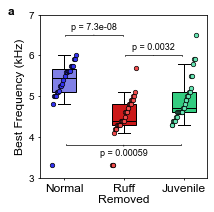

<AxesSubplot:ylabel='Best Frequency (kHz)'>

In [155]:
def fig7a(ax = None):
    if ax is None:
        standalone = True
        fig, ax = plt.subplots(figsize = [3,3])
    else:
        standalone = False
        
    posit = [1,2,3]
    bplot = ax.boxplot([czbest, dtbest, jvbest], patch_artist = True, sym = "", widths = 0.4,\
              positions = posit, labels = ['Normal Owls', 'Ruffcut Owls', 'Juvenile Owls'], zorder = 5)

    colors = [[0.2, 0.2, 0.95], [0.95, 0.3, 0.3], [0.4, 0.9, 0.7]]
    for i, (sc) in enumerate((czbest,dtbest,jvbest)):
        ax.scatter(np.linspace(posit[i]-.2,posit[i]+.2, num = len(sc)), np.sort(sc), zorder = 6, \
                  linewidth = .7, s = 20, edgecolors = 'black', color = colors[i])

    colors = [[0.5, 0.5, 0.9], [0.8, 0.1, 0.1], [0.2, 0.8, 0.5]]
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('black')
    ax.set_ylabel('Best Frequency (kHz)')
    ax.set_ylim([3000, 7000])
    ax.set_yticks(np.arange(3000,7001,1000))
    ax.set_yticklabels([3,4,5,6,7])
    ax.set_xticklabels(['Normal', 'Ruff\nRemoved', 'Juvenile'], fontsize = 12)

    plt.xlim([0.6,3.4])
    ax.text(0.05,7000, 'a', fontsize = 12, fontweight = 'bold' )

    ax.annotate(f'p = {cdbest[1]:.2g}', xy=(1.5, 6500), xytext=(1.5, 6600), xycoords='data', 
                fontsize=9, ha='center', va='bottom',
                arrowprops=dict(arrowstyle='-[, widthB=3.2, lengthB=.1', lw=.7))
    ax.annotate(f'p = {djbest[1]:.2g}', xy=(2.5, 6000), xytext=(2.5, 6100), xycoords='data', 
                fontsize=9, ha='center', va='bottom',
                arrowprops=dict(arrowstyle='-[, widthB=3.2, lengthB=.1', lw=.7))
    ax.annotate(f'p = {cjbest[1]:.2g}', xy=(2.0, 3800), xytext=(2.0, 3500), xycoords='data', 
                fontsize=9, ha='center', va='bottom',
                arrowprops=dict(arrowstyle='-[, widthB=6.4, lengthB=.1', lw=.7))

    
    if standalone:
        plt.show()
        file_name = 'boxplots_best.png'
        filname = os.path.join(fildir, file_name)
        fig.savefig(filname, bbox_inches='tight')
    return ax
fig7a()

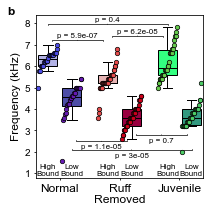

<AxesSubplot:ylabel='Frequency (kHz)'>

In [157]:
def fig7b(ax = None):
    if ax is None:
        standalone = True
        fig, ax = plt.subplots(figsize = [3,3])
    else:
        standalone = False
   
    posit_hi = [.75,2,3.25]
    posit_lo = [1.25,2.5,3.75]


    bplot = ax.boxplot([czhi, dthi, jvhi], bootstrap = 1000, patch_artist = True, sym = "",\
               positions = posit_hi, widths = 0.4, zorder = 5)

    colors = [[0.3, 0.3, 0.9], [0.9, 0.3, 0.3], [0.4, 0.8, 0.3]]
    for i, (sc) in enumerate((czhi,dthi,jvhi)):
        ax.scatter(np.linspace(posit_hi[i]-0.2,posit_hi[i]+0.2, num = len(sc)), np.sort(sc), zorder = 6, \
                   linewidth = .7, s = 20, edgecolors = 'black', color = colors[i])

    colors = [[0.7, 0.7, 0.9], [0.9, 0.7, 0.7], [0.2, 1.0, 0.5]]
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('black')     


    bplot = ax.boxplot([czlo, dtlo, jvlo], bootstrap = 1000, patch_artist = True, sym = "",\
               positions = posit_lo, widths = 0.4, zorder = 5)
    colors = [[0.4, 0.1, 0.7], [0.8, 0, 0.1], [0.3, 0.8, 0.4]]
    for i, (sc) in enumerate((czlo,dtlo,jvlo)):
        ax.scatter(np.linspace(posit_lo[i]-0.2,posit_lo[i]+0.2, num = len(sc)), np.sort(sc), zorder = 6, \
                  linewidth = .7, s = 20, edgecolors = 'black', color = colors[i])

    colors = [[0.3, 0.3, 0.65], [0.6, 0, 0.25], [0.2, 0.6, 0.5]]
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('black')

    ax.set_ylabel('Frequency (kHz)')
    ax.set_xticks([1, 2.25, 3.5])
    ax.set_xticklabels(['Normal', 'Ruff\nRemoved', 'Juvenile'], fontsize = 12)
    ax.set_yticks(np.arange(1000,8400,1000))
    ax.set_yticklabels([1,2,3,4,5,6,7,8])

    ax.set_ylim([800, 8400])
    ax.set_xlim([0.5, 4])

    for hi in posit_hi:
        ax.text(hi ,900, 'High\nBound', horizontalalignment = 'center', ma = 'center', fontsize = 8)
    for lo in posit_lo:
        ax.text(lo ,900, 'Low\nBound', horizontalalignment = 'center', ma = 'center', fontsize = 8)


    ax.annotate(f'p = {cdhi[1]:.2g}', xy=(1.375, 7200), xytext=(1.375, 7300), xycoords='data', 
                fontsize=8, ha='center', va='bottom',
                arrowprops=dict(arrowstyle='-[, widthB=3.2, lengthB=0.1', lw=.7))
    ax.annotate(f'p = {djhi[1]:.2g}', xy=(2.625, 7400), xytext=(2.625, 7500), xycoords='data', 
                fontsize=8, ha='center', va='bottom',
                arrowprops=dict(arrowstyle='-[, widthB=3.2, lengthB=0.1', lw=.7))
    ax.annotate(f'p = {cjhi[1]:.2g}', xy=(2.0, 7950), xytext=(2.0, 8050), xycoords='data', 
                fontsize=8, ha='center', va='bottom',
                arrowprops=dict(arrowstyle='-[, widthB=7.5, lengthB=0.1', lw=.7))

    ax.annotate(f'p = {cdlo[1]:.2g}', xy=(1.875, 2500), xytext=(1.875, 2400), xycoords='data', 
                fontsize=8, ha='center', va='top',
                arrowprops=dict(arrowstyle='-[, widthB=3.2, lengthB=0.1', lw=.7))
    ax.annotate(f'p = {djlo[1]:.2g}', xy=(3.125, 2800), xytext=(3.125, 2700), xycoords='data', 
                fontsize=8, ha='center', va='top',
                arrowprops=dict(arrowstyle='-[, widthB=3.2, lengthB=0.1', lw=.7))
    ax.annotate(f'p = {cjlo[1]:.2g}', xy=(2.5, 2100), xytext=(2.5, 2000), xycoords='data', 
                fontsize=8, ha='center', va='top',
                arrowprops=dict(arrowstyle='-[, widthB=7.5, lengthB=0.1', lw=.7))
    ax.text(-.1,8400, 'b', fontsize = 12, fontweight = 'bold' )

    if standalone:
        plt.show()
        file_name = 'boxplots_sum.png'
        filname = os.path.join(fildir, file_name)
        fig.savefig(filname, bbox_inches='tight')
    return ax
fig7b()

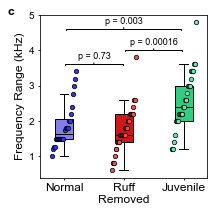

<AxesSubplot:ylabel='Frequency Range (kHz)'>

In [160]:
def fig7c(ax = None):
    if ax is None:
        standalone = True
        fig, ax = plt.subplots(figsize = [3,3])
    else:
        standalone = False

    posit = [1, 2, 3]
    bplot = ax.boxplot([czfrtrg, dtfrtrg, jvfrtrg], patch_artist = True, sym = "",\
              positions = posit, labels = ['Normal Owls', 'Ruffcut Owls', 'Juvenile Owls'])

    colors = [[0.2, 0.2, 0.95], [0.95, 0.3, 0.3], [0.4, 0.9, 0.7]]
    for i, (sc) in enumerate((czfrtrg, dtfrtrg, jvfrtrg)):
        ax.scatter(np.linspace(posit[i]-.2,posit[i]+.2, num = len(sc)), np.sort(sc), zorder = 6, \
                  linewidth = .7, s = 20, edgecolors = 'black', color = colors[i])

    colors = [[0.5, 0.5, 0.9], [0.8, 0.1, 0.1], [0.2, 0.8, 0.5]]
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('black')
    ax.set_ylabel('Frequency Range (kHz)')
    plt.xlim([0.6,3.4])
    ax.text(0.05,5000, 'c', fontsize = 12, fontweight = 'bold' )

    ax.set_yticks(np.arange(1000,5001,1000))
    ax.set_xticklabels(['Normal', 'Ruff\nRemoved', 'Juvenile'], fontsize = 12)
    ax.set_yticklabels([1,2,3,4,5])
    

    ax.annotate(f'p = {cdrg[1]:.2g}', xy=(1.5, 3600), xytext=(1.5, 3700), xycoords='data', 
                fontsize=9, ha='center', va='bottom',
                arrowprops=dict(arrowstyle='-[, widthB=3.2, lengthB=.1', lw=1))
    ax.annotate(f'p = {djrg[1]:.2g}', xy=(2.5, 4000), xytext=(2.5, 4100), xycoords='data', 
                fontsize=9, ha='center', va='bottom',
                arrowprops=dict(arrowstyle='-[, widthB=3.2, lengthB=.1', lw=1))
    ax.annotate(f'p = {cjrg[1]:.2g}', xy=(2.0, 4600), xytext=(2.0, 4700), xycoords='data', 
                fontsize=9, ha='center', va='bottom',
                arrowprops=dict(arrowstyle='-[, widthB=6.4, lengthB=.1', lw=1))

    if standalone:
        plt.show()
        file_name = 'freq_box_Hz.png'
        filname = os.path.join(fildir, file_name)
        fig.savefig(filname, bbox_inches='tight')
    return ax

fig7c()

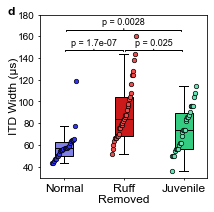

<AxesSubplot:ylabel='ITD Width (μs)'>

In [165]:
def fig7d(ax = None):
    if ax is None:
        standalone = True
        fig, ax = plt.subplots(figsize = [3,3])
    else:
        standalone = False
        
    posit = [1, 2, 3]
    bplot = ax.boxplot([czfrtwid, dtfrtwid, jvfrtwid], patch_artist = True, sym = "",\
              positions = posit, labels = ['Normal Owls', 'Ruff-Removed Owls', 'Juvenile Owls'])

    colors = [[0.2, 0.2, 0.95], [0.95, 0.3, 0.3], [0.4, 0.9, 0.7]]
    for i, (sc) in enumerate((czfrtwid, dtfrtwid, jvfrtwid)):
        ax.scatter(np.linspace(posit[i]-.2,posit[i]+.2, num = len(sc)), np.sort(sc), zorder = 6, \
                  linewidth = .7, s = 20, edgecolors = 'black', color = colors[i])

    colors = [[0.5, 0.5, 0.9], [0.8, 0.1, 0.1], [0.2, 0.8, 0.5]]
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('black')
    ax.set_ylabel('ITD Width (μs)', va = 'center')
    plt.xlim([0.6,3.4])
    ax.set_xticklabels(['Normal', 'Ruff\nRemoved', 'Juvenile'], fontsize = 12)
    ax.text(0.05,180, 'd', fontsize = 12, fontweight = 'bold' )
    ax.set_yticks(np.arange(40,181,20))
    ax.set_yticklabels(np.arange(40,181,20), horizontalalignment = 'right')

    ax.annotate(f'p = {cdwid[1]:.2g}', xy=(1.5, 147), xytext=(1.5, 150), xycoords='data', 
                fontsize=9, ha='center', va='bottom',
                arrowprops=dict(arrowstyle='-[, widthB=3.2, lengthB=0.1', lw=1))
    ax.annotate(f'p = {djwid[1]:.2g}', xy=(2.5, 147), xytext=(2.5, 150), xycoords='data', 
                fontsize=9, ha='center', va='bottom',
                arrowprops=dict(arrowstyle='-[, widthB=3.2, lengthB=0.1', lw=1))
    ax.annotate(f'p = {cjwid[1]:.2g}', xy=(2.0, 166), xytext=(2.0, 169), xycoords='data', 
                fontsize=9, ha='center', va='bottom',
                arrowprops=dict(arrowstyle='-[, widthB=6.4, lengthB=0.1', lw=1))


    if standalone:
        plt.show()
        file_name = 'itdwidth_box_Hz.png'
        filname = os.path.join(fildir, file_name)
        fig.savefig(filname, bbox_inches='tight')
    return ax
fig7d()

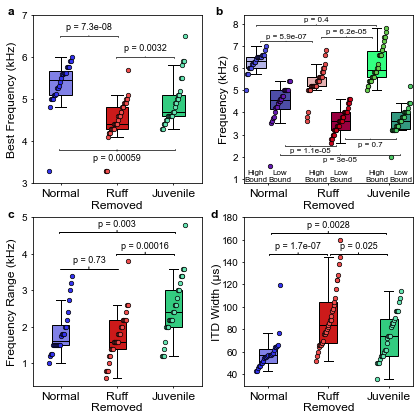

In [167]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize= (6, 6))

fig7a(ax1)
fig7b(ax2)
fig7c(ax3)
fig7d(ax4)

plt.tight_layout()
plt.subplots_adjust( bottom=None, right=None, top = None, wspace=.25, hspace=.2)


file_name = 'fig7.png'
filname = os.path.join(fildir, file_name)
fig.savefig(filname, bbox_inches = 'tight')

In [32]:
#ICCls

In [33]:
#only use units that are good, and are tuned to ITD
dt = dt[dt['Use?'] == 'yes']
allunits = dt.index[~dt['Best ITD'].isnull()].tolist()
#use only the for sure ICx units
iccllist = dt[dt['Nucleus'] == 'ICCls']
iccl = iccllist.index[~iccllist['Best ITD'].isnull()].tolist()
#set use to be allunits or icx
iccluse = iccl
iccln = dt['Best ITD'][iccluse].size

In [34]:
icclrandnu = np.empty_like(dt['Best ITD'][iccluse])
for n in range(icclrandnu.size):
    icclrandnu[n] = np.random.randint(-12,12,1)

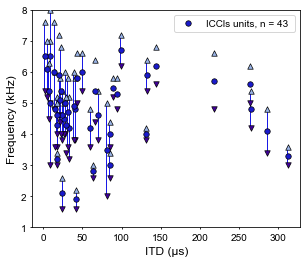

In [36]:
fig, ax = plt.subplots(figsize = [4*1.2,4])

ax.scatter(np.abs(dt['Best ITD'][iccluse] + icclrandnu), dt['Low Freq'][iccluse], marker = 'v', color = [0.25, 0, 0.6],   edgecolor = 'black', \
           linewidth = 0.7, s=30, zorder=12)
ax.scatter(np.abs(dt['Best ITD'][iccluse] + icclrandnu), dt['High Freq'][iccluse], marker = '^', color = [0.6, 0.7, 0.9], edgecolor = 'black', \
           linewidth = 0.7, s=30, zorder=12)
ax.scatter(np.abs(dt['Best ITD'][iccluse] + icclrandnu), dt['Best Freq'][iccluse], marker = 'o', color = [0.1, 0.1, 0.8], edgecolor = 'black', \
           linewidth = 0.7, s =30, zorder=12, \
          label = f'ICCls units, n = {iccln} ')
for nurep, ITD  in enumerate(iccluse):
    ax.bar(np.abs(dt['Best ITD'][ITD] + icclrandnu[nurep]), dt['High Freq'][ITD] - dt['Low Freq'][ITD], 1, dt['Low Freq'][ITD], color = [0.1, .1, 0.9 ]) 
    
ax.set_yticks(np.linspace(1000,8000,8))
ax.set_yticklabels([1,2,3,4,5,6,7,8])
    
#ax.plot(np.abs(cz['Best ITD']), linreg.intercept + linreg.slope*np.abs(cz['Best ITD']), 'r', linewidth = 5)
#ax.plot(np.abs(cz['Best ITD']), 5758 + -17.11*np.abs(cz['Best ITD']), 'b', linewidth = 5)
ax.set_ylim([1000, 8000])
plt.ylabel('Frequency (kHz)')
plt.xlabel('ITD (μs)')
plt.gca().legend(loc="upper right")
plt.show()
file_name = 'Haircut_ICCls.png'
filname = os.path.join(fildir, file_name)
#fig.savefig(filname, bbox_inches='tight')

In [37]:
##Example unit

In [19]:
d = '2021-1013'
m =  '44.07'
n = '0' + m

abifile  = pedman.pyxdphys.XDdata(fr'F:\xdphys\{d}\{m}\{n}.0.abi')
ildfile  = pedman.pyxdphys.XDdata(fr'F:\xdphys\{d}\{m}\{n}.1.iid')
bcfile   = pedman.pyxdphys.XDdata(fr'F:\xdphys\{d}\{m}\{n}.2.gen')
itdfile  = pedman.pyxdphys.XDdata(fr'F:\xdphys\{d}\{m}\{n}.3.itd')
bffile   = pedman.pyxdphys.XDdata(fr'F:\xdphys\{d}\{m}\{n}.4.bf')
#sptfile  = pedman.pyxdphys.XDdata(r'D:\xdphys\2021-0811\046.00\046.00.5.iid')

In [20]:
%run ./QuickXDPhys-BasicFrequencyTuning.ipynb

[100.85, 20.0]

[-297.29, -22.0]

[499.0, 62.0]

best ITD:


[20.0, -22.0, 62.0, 0.94]

best freq:


[3300.0, 2600.0, 4000.0]

best ILD:


array([0.])

Gaussian or Sigmoidal


array([0.95, 0.19])

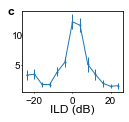

<AxesSubplot:xlabel='ILD (dB)'>

In [21]:
#Best ILD
def fig2c(ax = None):
    if ax is None:
        standalone = True
        fig, ax = plt.subplots(figsize = [1.5*1.2,1.5])
    else:
        standalone = False

    ax.errorbar(ildx, ildy, sps.stats.sem(ildspikecounts, axis=1), linewidth=1,marker = 'o', markersize = 1)
    ax.set_xlabel('ILD (dB)', va = 'center')
    #ax.set_ylabel('Spike Count')
    ax.tick_params(axis='both', length = 1)
    ax.set_yticks([5, 10])
    ax.set_yticklabels([5, 10], ha = 'center')
    
    ax.text(-0.15,.95, 'c', fontsize = 12, fontweight = 'bold' , transform = ax.transAxes)

    if standalone:
        plt.show()
        file_name = 'ex_ILD.png'
        filname = os.path.join(fildir, file_name)
        #fig.savefig(filname, bbox_inches='tight')
    return ax

fig2c()

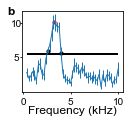

<AxesSubplot:xlabel='Frequency (kHz)'>

In [22]:
#Best Freq

def fig2b(ax = None):
    if ax is None:
        standalone = True
        fig, ax = plt.subplots(figsize = [1.5*1.2,1.5])
    else:
        standalone = False
        
    ax.errorbar(bffile.params['bf']['range'], bfspikecounts.mean(axis=1), sps.stats.sem(bfspikecounts, axis=1),\
             linewidth = 1, markersize = 1)
    ax.set_xlabel('Frequency (kHz)', va = 'center')
    #ax.set_ylabel('Spike Count')
    ax.hlines((np.max(bfy) - np.min(bfy))/2 + np.min(bfy), 400, 10000, color = 'black', linewidths = 2)
    ax.scatter([freq_lo, freq_hi], [lofr, hifr], color = 'black', s = 10)
    ax.scatter([best_freq], [np.max(bfy)], marker = 'o',color = 'red', zorder = 1, s = 10)
    ax.set_yticks([ 5, 10])
    ax.set_yticklabels([ 5, 10], ha = 'center')
    ax.set_xticks([ 0, 5000, 10000])
    ax.set_xticklabels([ 0, 5, 10], ha = 'center')
    
    ax.text(-0.15,.95, 'b', fontsize = 12, fontweight = 'bold' , transform = ax.transAxes)

    if standalone:
        plt.show()
        file_name = 'ex_ILD.png'
        filname = os.path.join(fildir, file_name)
        #fig.savefig(filname, bbox_inches='tight')
    return ax
fig2b()

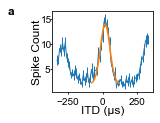

<AxesSubplot:xlabel='ITD (µs)', ylabel='Spike Count'>

In [23]:
#Best ITD Graph

def fig2a(ax = None):
    if ax is None:
        standalone = True
        fig, ax = plt.subplots(figsize = [1.5*1.2,1.5])
    else:
        standalone = False    
    ax.errorbar(itdfile.params['itd']['range'], itdspikecounts.mean(axis=1), sps.stats.sem(itdspikecounts, axis=1), \
               linewidth = 1, markersize = 1)
    ax.plot(np.arange(-80,121,10), Gaussian(np.arange(-80,121,10), *ITDopt), zorder = 5, linewidth = 1.5)
    ax.set_xlabel('ITD (µs)', va = 'center')
    ax.set_ylabel('Spike Count', va = 'center')
    ax.set_yticks([ 5, 10, 15])
    ax.set_yticklabels([ 5, 10, 15], ha = 'center')
    
    ax.text(-0.45,.95, 'a', fontsize = 12, fontweight = 'bold' , transform = ax.transAxes)

    if standalone:
        plt.show()
        file_name = 'ex_ITD.png'
        filname = os.path.join(fildir, file_name)
        #fig.savefig(filname, bbox_inches='tight')
    return ax
fig2a()

<AxesSubplot:xlabel='ILD (dB)'>

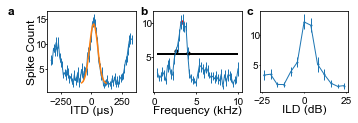

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (4.5*1.2, 1.5))

fig2a(ax1)
fig2b(ax2)
fig2c(ax3)

In [25]:
#ILD

In [26]:
czxildi, czyildi, czyild1, czyild2 = regCI(cz['Best ITD'], cz['ILD'], czn, 0.05)
dtxildi, dtyildi, dtyild1, dtyild2 = regCI(dt['Best ITD'][use], dt['ILD'][use], dtn, 0.05)
jvxildi, jvyildi, jvyild1, jvyild2 = regCI(jv['Best ITD'], jv['ILD'], jvn, 0.05)

In [27]:
ildlinreg = sps.stats.linregress(np.abs(dt['Best ITD'][use]), dt['ILD'][use])
czildlinreg = sps.stats.linregress(np.abs(cz['Best ITD']), cz['ILD'])
jvildlinreg = sps.stats.linregress(np.abs(jv['Best ITD']), jv['ILD'])


slopediff(dt['Best ITD'][use], dt['ILD'][use], cz['Best ITD'], cz['ILD'], dtn, czn)

[3.679724719557728, 0.00023348586084959703]

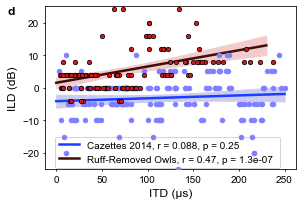

<AxesSubplot:xlabel='ITD (μs)', ylabel='ILD (dB)'>

In [28]:
def fig2d(ax = None):
    if ax is None:
        standalone = True
        fig, ax = plt.subplots(figsize = [4.5,3])
    else:
        standalone = False    
        
    ax.scatter(np.abs(dt['Best ITD'][use] + randnu), dt['ILD'][use], marker = 'o', color = [0.8, 0.1, 0.1], \
               linewidths = 0.7, edgecolor = 'black', s =20, zorder=11)
    ax.scatter(np.abs(cz['Best ITD']), cz['ILD'], marker = 'o', color = [0.5, 0.5, 1], s = 20, zorder = 10)
    #ax.scatter(np.abs(jv['Best ITD']), jv['ILD'], marker = 'o', color = [0.2, 0.9, 0.5], s = 100)
    
    czline, = ax.plot(czxildi, czyildi, color = [0.1, 0.25, 1],  linewidth = 2.5, \
           label = f'Cazettes 2014, r = {czildlinreg.rvalue:.2g}, p = {czildlinreg.pvalue:.2g}', zorder = 9)
    ax.fill_between(czxildi, czyild1, czyild2, color = [0.8, 0.8, .95], zorder = 1)
    
    dtline, = ax.plot(dtxildi, dtyildi, color = [0.25, 0.05, 0.05],  linewidth = 2.5, \
           label = f'Ruff-Removed Owls, r = {ildlinreg.rvalue:.2g}, p = {ildlinreg.pvalue:.2g} ', zorder = 8)
    ax.fill_between(dtxildi, dtyild1, dtyild2, color = [0.95, 0.8, 0.8], zorder = 3)
    
    ax.text(-0.15,.95, 'd', fontsize = 12, fontweight = 'bold' , transform = ax.transAxes)
    
    plt.ylabel('ILD (dB)')
    plt.xlabel('ITD (μs)')
    ax.set_ylim([-25, 25])
    #legend1 = plt.gca().legend(handles = [czline], loc = [.35, .01])
    #ax.add_artist(legend1)
    #legend2 = plt.gca().legend(handles = [dtline], loc = [.25, .87])
    plt.gca().legend( loc = [.04, .01])


    if standalone:
        plt.show()
        file_name = 'ruffcut_ILD.png'
        filname = os.path.join(fildir, file_name)
        #fig.savefig(filname, bbox_inches='tight')
    return ax
fig2d()

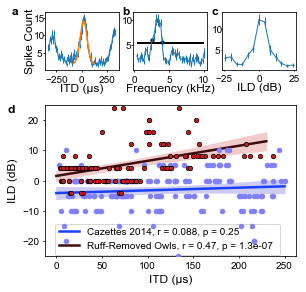

In [29]:
fig = plt.figure(facecolor= 'white')
fig.set_figheight(4.5)
fig.set_figwidth(4.5)

ax1 = plt.subplot2grid(shape=(3,3), loc = (0,0), colspan = 1)  
ax2 = plt.subplot2grid(shape=(3,3), loc = (0,1), colspan = 1)  
ax3 = plt.subplot2grid(shape=(3,3), loc = (0,2), colspan = 1)  
ax4 = plt.subplot2grid(shape=(3,3), loc = (1,0), colspan = 3, rowspan = 2)  

fig2a(ax1)
fig2b(ax2)
fig2c(ax3)
fig2d(ax4)

#plt.tight_layout()
plt.subplots_adjust( bottom=None, right=None, top = None, wspace=.2, hspace=.6)

file_name = 'Fig2_whole.png'
filname = os.path.join(fildir, file_name)
fig.savefig(filname, bbox_inches='tight')

In [ ]:
#fig2 = plt.figure()
#fig2.tight_layout()
#
#ax1 = plt.subplot(2,3,1)
#fig2a(ax1)
#ax2 = plt.subplot(2,3,2)
#fig2b(ax2)
#ax3 = plt.subplot(2,3,3)
#fig2c(ax3)
#ax4 = plt.subplot(2,1,2)
#fig2d(ax4)
#
#plt.subplots_adjust( bottom=None, right=None, top=None, wspace=None, hspace=.4)